In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()

········


Extracting relevent information about film features to make the predictions about movies rentals. Then extracting all the film titles with True or False for rental in May2005. Finally merginf 2 datasets.

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''select f.title, f.rental_rate, f.rating, c.name as category from film as f
join film_category as fc
on f.film_id = fc.film_id
join category as c
on fc.category_id = c.category_id;'''

film_features = pd.read_sql_query(query, engine)
film_features.head()

,title,rental_rate,rating,category
0,AMADEUS HOLY,0.99,PG,Action
1,AMERICAN CIRCUS,4.99,R,Action
2,ANTITRUST TOMATOES,2.99,NC-17,Action
3,ARK RIDGEMONT,0.99,NC-17,Action
4,BAREFOOT MANCHURIAN,2.99,G,Action


In [3]:
query = '''select distinct f.title,
max(case 
     when r.rental_date between "2005-05-01" and "2005-05-31" then TRUE
	else FALSE
end) as "rented_in_may"
from film as f
left join inventory as i
on f.film_id = i.film_id
left join rental as r
on i.inventory_id = r.inventory_id
GROUP BY f.title
;'''

rented_may2005 = pd.read_sql_query(query, engine)
rented_may2005.head()

,title,rented_in_may
0,ACADEMY DINOSAUR,1
1,ACE GOLDFINGER,0
2,ADAPTATION HOLES,0
3,AFFAIR PREJUDICE,1
4,AFRICAN EGG,1


In [4]:
may2005_film_features = pd.merge(left = film_features,
                                 right = rented_may2005, 
                                 how = 'inner', 
                                 left_on = "title", 
                                 right_on= "title")
display(may2005_film_features.shape)
may2005_film_features.head()

(1000, 5)

,title,rental_rate,rating,category,rented_in_may
0,AMADEUS HOLY,0.99,PG,Action,1
1,AMERICAN CIRCUS,4.99,R,Action,1
2,ANTITRUST TOMATOES,2.99,NC-17,Action,0
3,ARK RIDGEMONT,0.99,NC-17,Action,0
4,BAREFOOT MANCHURIAN,2.99,G,Action,1


In [5]:
may2005_film_features.dtypes

title             object
rental_rate      float64
rating            object
category          object
rented_in_may      int64
dtype: object

In [6]:
may2005_film_features.isna().sum()

title            0
rental_rate      0
rating           0
category         0
rented_in_may    0
dtype: int64

Checking unique values for all the selected features

In [7]:
may2005_film_features["rental_rate"].unique()

array([0.99, 4.99, 2.99])

In [8]:
may2005_film_features["rating"].unique()

array(['PG', 'R', 'NC-17', 'G', 'PG-13'], dtype=object)

In [9]:
may2005_film_features["category"].unique()

array(['Action', 'Animation', 'Children', 'Classics', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Foreign', 'Games', 'Horror',
       'Music', 'New', 'Sci-Fi', 'Sports', 'Travel'], dtype=object)

Encoding the features, either with a LabelEncoder or with a OneHotEncoder

In [10]:
from sklearn.preprocessing import LabelEncoder
rental_rate_df = pd.DataFrame(may2005_film_features, columns=['rental_rate'])
labelencoder = LabelEncoder()
rental_rate_df['rental_rate_enc'] = labelencoder.fit_transform(rental_rate_df['rental_rate'])
rental_rate_df = rental_rate_df.drop(["rental_rate"], axis=1)

In [14]:
from sklearn.preprocessing import OneHotEncoder

cat_columns = may2005_film_features.select_dtypes(include = "object").drop(["title"], axis=1)
cat_columns
encoder = OneHotEncoder(drop='first')
encoder.fit(cat_columns)
print(encoder.categories_)

encoded = encoder.transform(cat_columns).toarray()
print(encoded)
onehot_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out())
onehot_encoded.head()

[array(['G', 'NC-17', 'PG', 'PG-13', 'R'], dtype=object), array(['Action', 'Animation', 'Children', 'Classics', 'Comedy',
       'Documentary', 'Drama', 'Family', 'Foreign', 'Games', 'Horror',
       'Music', 'New', 'Sci-Fi', 'Sports', 'Travel'], dtype=object)]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Splitting the dataset into train and test parts. And using logistic regression to predict categorical variables.

In [15]:
y = may2005_film_features["rented_in_may"]
X = pd.concat([onehot_encoded, rental_rate_df], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [16]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(X_train, y_train)

In [23]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(X_test)
print(classification.score(X_test, y_test))
print(classification.score(X_test, y_test))

0.615
0.615


The model can predict 61.5% of all the values. The result is not very high.

In [18]:
print(y_test.value_counts())

1    133
0     67
Name: rented_in_may, dtype: int64


In [19]:
pd.Series(predictions).value_counts()

1    178
0     22
dtype: int64

Checking the results of the test set on confusion matrix. I think the dataset is too small (1000 entries (200 in the test set)) to make predictions.

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[  6,  61],
       [ 16, 117]], dtype=int64)

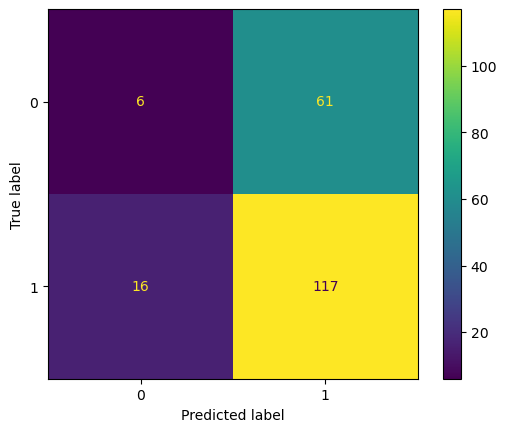

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_test = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_)
disp.plot()
plt.show()

In [28]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, predictions)

-0.036897387557231376

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.27      0.09      0.13        67
           1       0.66      0.88      0.75       133

    accuracy                           0.61       200
   macro avg       0.47      0.48      0.44       200
weighted avg       0.53      0.61      0.55       200

